# Startified KFold for the OM dataset

This code is provided to split a dataset in COCO (+ YOLO later) format given labels distributions across the dataset. This algorithms is indended for preserving the samples percentages for each class in order to provide a smoother generalization and adress class imbalance. 

In [1]:
# # Example usage

# import dataset
# from dataset import coco_to_yolo_converter

# input_path = "./roboflow_datasets/xmm_om_artefacts_512-7-COCO/"
# output_path = "./roboflow_datasets/xmm_om_artefacts_512-7-YOLO/train/"
# input_json_train = "train/skf_train_annotations.coco.json"

# converter = coco_to_yolo_converter.COCOToYOLOConverter(input_path, output_path, input_json_train)
# converter.convert()

## Setup

In [168]:
import json
from sklearn.model_selection import StratifiedKFold
import numpy as np
import os

## Load the dataset

In [170]:
dataset_path = './roboflow_datasets/xmm_om_artefacts_512-20-COCO/'
json_file_path = dataset_path+'train/_annotations.coco.json'
dest_path = './roboflow_datasets/xmm_om_artefacts_512-20-COCO-splits/'

with open(json_file_path) as f:
    data_in = json.load(f)
data_in['categories']

# create the destination folder if it doesn't exist already
if not os.path.exists(dest_path):
    os.mkdir(dest_path)

In [171]:
data_in['categories']

[{'id': 0, 'name': 'artefacts', 'supercategory': 'none'},
 {'id': 1, 'name': 'central-ring', 'supercategory': 'artefacts'},
 {'id': 2, 'name': 'smoke-ring', 'supercategory': 'artefacts'},
 {'id': 3, 'name': 'star-loop', 'supercategory': 'artefacts'}]

In [172]:
# # running the script multiple times may change the redistribution, 
# # thus we need to make sure that we won't keep the old files

# import glob

# files = glob.glob(f'{dest_valid_path}/*')

# for file in files:
#     os.remove(file)

## Stratified KFold

In [173]:
images, labels = [], []

for k in range(len(data_in['images'])):
    img_id = data_in['images'][k]['id']
    annotations = [data_in['annotations'][j] for j in range(len(data_in['annotations'])) if data_in['annotations'][j]['image_id'] == img_id]
    categories = set(str(annot['category_id']) for annot in annotations)
    images.append([img_id])
    labels.append(''.join(list(categories)))
        
images, labels = np.array(images), np.array(labels)

In [174]:
labels

array(['321', '2', '312', '312', '32', '1', '3', '31', '312', '321', '3',
       '21', '32', '1', '2', '32', '1', '312', '321', '321', '321', '2',
       '32', '32', '321', '32', '321', '321', '', '321', '31', '31', '32',
       '2', '32', '3', '31', '21', '31', '2', '321', '32', '31', '32',
       '312', '32', '3', '321', '321', '1', '32', '21', '32', '21', '312',
       '1', '321', '3', '3', '3', '1', '3', '21', '31', '21', '32', '321',
       '31', '1', '3', '312', '1', '31', '3', '31', '1', '31', '31', '1',
       '1', '3', '3', '21', '31', '31', '32', '32', '31', '31', '1',
       '321', '32', '31', '321', '312', '32', '', '312', '312', '32', '3',
       '21', '32', '32', '3', '312', '321', '312', '32', '1', '312', '32',
       '1', '312', '3', '312', '31', '31', '312', '3', '31', '31', '',
       '1', '', '1', '1', '321', '1', '', '321', '32', '3', '32', '312',
       '1', '1', '3', '32', '3', '321', '21', '321', '32', '1', '312',
       '1', '32', '31', '321', '', '32', '31', '3

The resulting arrays' size equals to the number of annotations because image ids are repeated for each label associated with them.

In [175]:
images.shape, labels.shape

((727, 1), (727,))

Run the Stratified KFold split and generate train and valid datasets given the number of splits. 

The split percentage is calculated depending on the `n_splits` parameter:

> train_percentage = int(100 * 1/n_splits)
>
> valid_percentage = 100 - train_percentage

In [176]:
skf_image_ids, skf_labels = {}, {}

n_splits = 3
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for i, (train_index, valid_index) in enumerate(skf.split(images, labels)):
    skf_image_ids[i] = {'train': images[train_index], 'valid': images[valid_index]}
    skf_labels[i] = {'train': labels[train_index], 'valid': labels[valid_index]}

In [177]:

# from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, KFold

# n_splits = 3
# skf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
# skf_image_ids, skf_labels = {}, {}

# for i, (train_index, valid_index) in enumerate(skf.split(images, labels)):
#     # print(f"Fold {i}:")
#     # print(f"  Train: Image index={images[train_index]}")
#     # print(f"  valid:  Image index={images[valid_index]}")
#     skf_image_ids[i] = {'train': images[train_index], 'valid': images[valid_index]}
#     skf_labels[i] = {'train': labels[train_index], 'valid': labels[valid_index]}

In [178]:
len(train_index), len(valid_index)

(485, 242)

In [179]:
len(skf_image_ids), 'splits'

(3, 'splits')

**Ensure that there are no image ids present in both splits.**

In [180]:
for i in range(n_splits):
    print("intersection", len(np.intersect1d(skf_image_ids[i]['train'], skf_image_ids[i]['valid'])))

intersection 0
intersection 0
intersection 0


**Ensure that the labels distribution is roughly the same between splits.**

In [181]:
labels_percentages = {}

for i in range(n_splits):
    train_k, valid_k = 0, 0
    train_labels_counts = {'0':0, '1':0, '2':0, '3':0}
    valid_labels_counts = {'0':0, '1':0, '2':0, '3':0}
    
    for j in range(len(skf_image_ids[i]['train'])):
        for cat in list(skf_labels[i]['train'][j]):
            train_labels_counts[cat] += 1
            train_k+=1
    
    for j in range(len(skf_image_ids[i]['valid'])):
        for cat in list(skf_labels[i]['valid'][j]):
            valid_labels_counts[cat] += 1
            valid_k+=1

    train_labels_counts = {cat:counts * 1.0/train_k for cat, counts in train_labels_counts.items()}
    valid_labels_counts = {cat:counts * 1.0/valid_k for cat, counts in valid_labels_counts.items()}
            
    labels_percentages[i] = {'train':train_labels_counts, 'valid':  valid_labels_counts}

In [182]:
labels_percentages

{0: {'train': {'0': 0.0,
   '1': 0.3408360128617363,
   '2': 0.28938906752411575,
   '3': 0.36977491961414793},
  'valid': {'0': 0.0,
   '1': 0.3404710920770878,
   '2': 0.2890792291220557,
   '3': 0.37044967880085655}},
 1: {'train': {'0': 0.0,
   '1': 0.3408360128617363,
   '2': 0.2883172561629153,
   '3': 0.3708467309753483},
  'valid': {'0': 0.0,
   '1': 0.3404710920770878,
   '2': 0.291220556745182,
   '3': 0.3683083511777302}},
 2: {'train': {'0': 0.0,
   '1': 0.3404710920770878,
   '2': 0.29014989293361887,
   '3': 0.3693790149892934},
  'valid': {'0': 0.0,
   '1': 0.34120171673819744,
   '2': 0.2875536480686695,
   '3': 0.37124463519313305}}}

In [183]:
labels_percentages

{0: {'train': {'0': 0.0,
   '1': 0.3408360128617363,
   '2': 0.28938906752411575,
   '3': 0.36977491961414793},
  'valid': {'0': 0.0,
   '1': 0.3404710920770878,
   '2': 0.2890792291220557,
   '3': 0.37044967880085655}},
 1: {'train': {'0': 0.0,
   '1': 0.3408360128617363,
   '2': 0.2883172561629153,
   '3': 0.3708467309753483},
  'valid': {'0': 0.0,
   '1': 0.3404710920770878,
   '2': 0.291220556745182,
   '3': 0.3683083511777302}},
 2: {'train': {'0': 0.0,
   '1': 0.3404710920770878,
   '2': 0.29014989293361887,
   '3': 0.3693790149892934},
  'valid': {'0': 0.0,
   '1': 0.34120171673819744,
   '2': 0.2875536480686695,
   '3': 0.37124463519313305}}}

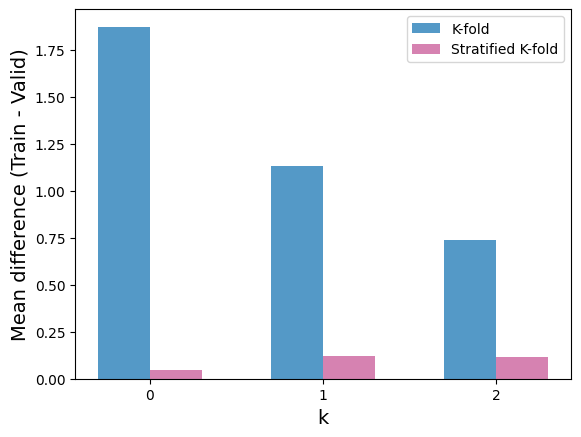

In [167]:
import matplotlib.pyplot as plt
import numpy as np

results = {
    0: {'train': {'1': 0.3373362445414847, '2': 0.28820960698689957, '3': 0.37445414847161573},
        'valid': {'1': 0.3492723492723493, '2': 0.2765072765072765, '3': 0.37422037422037424}},
    1: {'train': {'1': 0.3361884368308351, '2': 0.28586723768736616, '3': 0.37794432548179874},
        'valid': {'1': 0.35205183585313177, '2': 0.28077753779697623, '3': 0.367170626349892}},
    2: {'train': {'1': 0.350635593220339, '2': 0.2786016949152542, '3': 0.3707627118644068},
        'valid': {'1': 0.32229580573951433, '2': 0.2958057395143488, '3': 0.3818984547461369}}
}

results_skf = {
    0: {'train':
       { 
   '1': 0.34156820622986034,
   '2': 0.28356605800214824,
   '3': 0.3748657357679914},
  'valid': {
   '1': 0.34120171673819744,
   '2': 0.2854077253218884,
   '3': 0.37339055793991416}},
 1: {'train': {
   '1': 0.34156820622986034,
   '2': 0.284640171858217,
   '3': 0.37379162191192267},
  'valid': {
   '1': 0.34120171673819744,
   '2': 0.2832618025751073,
   '3': 0.37553648068669526}},
 2: {'train': {
   '1': 0.34120171673819744,
   '2': 0.2843347639484979,
   '3': 0.37446351931330474},
  'valid': {
   '1': 0.3419354838709677,
   '2': 0.2838709677419355,
   '3': 0.3741935483870968}}}

colors = ['#89D8CD', '#9F156480', '#FFBCF880']

label_diffs = {i: {label: abs(results[i]['train'][label] - results[i]['valid'][label])
                   for label in results[i]['train']} for i in results}
label_diffs_skf = {i: {label: abs(results_skf[i]['train'][label] - results_skf[i]['valid'][label])
                   for label in results_skf[i]['train']} for i in results_skf}

diff_array = np.array([[label_diffs[iteration][label] for label in sorted(label_diffs[iteration])]
                       for iteration in sorted(label_diffs)])
mean_array = np.array([np.mean(diff_array[:, i])*100 for i in range(diff_array.shape[0])])

diff_array_skf = np.array([[label_diffs_skf[iteration][label] for label in sorted(label_diffs_skf[iteration])]
                       for iteration in sorted(label_diffs_skf)])
mean_array_skf = np.array([np.mean(diff_array_skf[:, i])*100 for i in range(diff_array_skf.shape[0])])


indices = np.arange(len(mean_array))

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.plot(indices, mean_array, 'o', label='K-fold', markersize=8)
# plt.plot(indices, mean_array_skf, 'o', label='Stratified K-fold', markersize=8)

# # Customizing the plot
# plt.xlabel('k', fontsize=14)
# plt.ylabel('Mean difference (Train - Valid)', fontsize=14)
# plt.title('Elements from Two Arrays', fontsize=16)
# plt.xticks(indices)
# plt.legend(fontsize=12)
# plt.grid(True)

# plt.show()


# labels = [data_in['categories'][1]['name'],data_in['categories'][2]['name'], data_in['categories'][3]['name']]
# iters = ['Iteration 1', 'Iteration 2', 'Iteration 3']

# x = np.arange(len(labels))  # the label locations
# width = 0.2  # the width of the bars

# fig, ax = plt.subplots(figsize=(10, 6))
# rects1 = ax.bar(x - width, np.mean(diff_array[:, 0]), width, label=iters[0], color=colors[0])
# rects2 = ax.bar(x, np.mean(diff_array[:, 1]), width, label=iters[1], color=colors[1])
# rects3 = ax.bar(x + width, np.mean(diff_array[:, 2]), width, label=iters[2], color=colors[2])

# ax.set_ylabel('Difference (Train - Valid)')
# # ax.set_title('Difference between Train and Valid Label Values by Iteration')
# ax.set_xticks(x)
# ax.set_xticklabels(iters)
# ax.legend()

# def autolabel(rects):
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(round(height, 4)),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 1),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')
#         ax.set_ylim(-0.02, 0.03)

# autolabel(rects1)
# autolabel(rects2)
# autolabel(rects3)
# fig.tight_layout()
# plt.savefig('./plots/skf_errors.png', dpi=400)
# plt.show()

# Bar width
width = 0.3

fig, ax = plt.subplots()
bars1 = ax.bar(indices - width/2, mean_array, width, label='K-fold', color='#5499C7')
bars2 = ax.bar(indices + width/2, mean_array_skf, width, label='Stratified K-fold', color='#D682B1')

# Adding labels and title
plt.xlabel('k', fontsize=14)
plt.ylabel('Mean difference (Train - Valid)', fontsize=14)
# ax.set_title('Comparison of Two Arrays Using Bar Plot', fontsize=16)
ax.set_xticks(indices)
ax.set_xticklabels([str(i) for i in indices])
ax.legend()
plt.savefig('./plots/kf_skf_errors.png', dpi=400)
plt.show()

In [153]:
mean_array, mean_array_skf

(array([0.019, 0.011, 0.007]), array([0.   , 0.001, 0.001]))

In [123]:
diff_array.shape, diff_array_skf

((3, 3),
 array([[0.00036649, 0.00184167, 0.00147518],
        [0.00036649, 0.00137837, 0.00174486],
        [0.00073377, 0.0004638 , 0.00026997]]))

In [115]:
np.mean(diff_array[:, 0])

0.018713097077995306

In [48]:
diff_array

array([[-0.0119361 ,  0.01170233,  0.00023377],
       [-0.0158634 ,  0.0050897 ,  0.0107737 ],
       [ 0.02833979, -0.01720404, -0.01113574]])

In [43]:
label_diffs

{0: {'1': -0.011936104730864594,
  '2': 0.011702330479623047,
  '3': 0.00023377425124149198},
 1: {'1': -0.015863399022296665,
  '2': 0.0050896998903899315,
  '3': 0.010773699131906733},
 2: {'1': 0.028339787480824663,
  '2': -0.01720404459909458,
  '3': -0.011135742881730082}}

## Update the dataset and save new annotations files

In [184]:
import shutil
import os

def make_split(data_in, train_index, valid_index):
    
    data_in_train = data_in.copy()
    data_in_valid = data_in.copy()
    
    data_in_train['images'] = [data_in['images'][train_index[i][0]] for i in range(len(train_index))]
    data_in_valid['images'] = [data_in['images'][valid_index[i][0]] for i in range(len(valid_index))]
    train_annot_ids, valid_annot_ids = [], []
    
    for img_i in data_in_train['images']:
        annotation_ids = [annot['id'] for annot in data_in_train['annotations'] if annot['image_id'] == img_i['id']]
        train_annot_ids +=annotation_ids
        
    for img_i in data_in_valid['images']:
        annotation_ids = [annot['id'] for annot in data_in_valid['annotations'] if annot['image_id'] == img_i['id']]
        valid_annot_ids +=annotation_ids
        
    data_in_train['annotations'] = [data_in_train['annotations'][id] for id in train_annot_ids]
    data_in_valid['annotations'] = [data_in_valid['annotations'][id] for id in valid_annot_ids]
    
    print(len(data_in_train['images']), len(data_in_valid['images']))
    return data_in_train, data_in_valid

for i in range(n_splits):
    dest_train_path_i = dest_path + f'train_{i+1}/'
    dest_valid_path_i = dest_path + f'valid_{i+1}/'
    os.mkdir(dest_train_path_i)
    os.mkdir(dest_valid_path_i)
    new_train_json_path = dest_train_path_i+'skf_train_annotations.coco.json'
    new_valid_json_path = dest_valid_path_i+'skf_valid_annotations.coco.json'
    data_in_train_i, data_in_valid_i = make_split(data_in, skf_image_ids[i]['train'], skf_image_ids[i]['valid'])

    with open(new_train_json_path, 'w') as f1, open(new_valid_json_path, 'w') as f2:
        json.dump(data_in_train_i, f1, indent=4)
        json.dump(data_in_valid_i, f2, indent=4)

    # Copy the filenames to the corresponding split directories
    train_filenames_i = list(set([image['file_name'] for image in data_in_train_i['images']]))
    valid_filenames_i = list(set([image['file_name'] for image in data_in_valid_i['images']]))
    print(len(train_filenames_i), len(valid_filenames_i))
    
    for filename in train_filenames_i:
        source_path = os.path.join(dataset_path+'train/', filename)
        dest_path_f = os.path.join(dest_train_path_i, filename)
        shutil.copy(source_path, dest_path_f)

    for filename in valid_filenames_i:
        source_path = os.path.join(dataset_path+'train/', filename)
        dest_path_f = os.path.join(dest_valid_path_i, filename)
        shutil.copy(source_path, dest_path_f)
    
    print("Files moved successfully.")

484 243
484 243
Files moved successfully.
485 242
485 242
Files moved successfully.
485 242
485 242
Files moved successfully.


**extract annotations given skf indices**

**save the new json data**

In [189]:
# new_train_json_path = dest_train_path_i+'skf_train_annotations.coco.json'
# new_valid_json_path = dest_valid_path_i+'skf_valid_annotations.coco.json'

# with open(new_train_json_path, 'w') as f1, open(new_valid_json_path, 'w') as f2:
#     json.dump(data_in_train, f1, indent=4)
#     json.dump(data_in_valid, f2, indent=4)

**Move the filenames to the corresponding split directories**